In [20]:
import pandas as pd

# Load the data into a pandas DataFrame
data = pd.read_csv('merged_lz_houston_data.csv', parse_dates=['DateTime'])

# Ensure 'Settlement Point Price' and 'QUANTITY' are treated as numeric columns.
# Coerce any errors during conversion to NaN, which will be handled during the filling process.
# Replace 'Settlement Point Price' with the actual column name from your CSV if it's different.
data['Settlement_Point_Price'] = pd.to_numeric(data['Settlement Point Price'], errors='coerce')
data['QUANTITY'] = pd.to_numeric(data['QUANTITY'], errors='coerce')

# Set 'DateTime' as the index
data.set_index('DateTime', inplace=True)

# Sort the DataFrame by DateTime to ensure it is in chronological order
data.sort_index(inplace=True)

# Resample the data to hourly frequency, aggregating with the mean
# Only numeric columns should be included in this operation.
data_hourly = data[['Settlement_Point_Price', 'QUANTITY']].resample('H').mean()

# Calculate the rolling mean for the past 7 days (168 hours)
rolling_mean = data_hourly.rolling(window=168, min_periods=1).mean()

# Fill missing values with the rolling mean
data_hourly_filled = data_hourly.fillna(rolling_mean)

# Forward fill any remaining missing values
data_hourly_filled.ffill(inplace=True)

# Backward fill any remaining missing values
data_hourly_filled.bfill(inplace=True)

# Ensure that 'ACCOUNT_NUMBER' is a column in the original 'data' dataframe
if 'ACCOUNT_NUMBER' in data.columns:
    # We need to join on the indices, which represent the DateTime after resampling
    data_with_account_info = data[['ACCOUNT_NUMBER']].join(data_hourly_filled, how='inner')

    # Split the data by 'ACCOUNT_NUMBER'
    account_a_hourly_filled = data_with_account_info[data_with_account_info['ACCOUNT_NUMBER'] == 'account_a']
    account_b_hourly_filled = data_with_account_info[data_with_account_info['ACCOUNT_NUMBER'] == 'account_b']
else:
    print("ACCOUNT_NUMBER column not found in the dataset.")

## Augmented Dickey-Fuller Test for Stationarity
We'll define a function to perform the ADF test and then apply it to the 'Settlement_Point_Price' and 'QUANTITY' columns for both Account A and B.

In [21]:
from statsmodels.tsa.stattools import adfuller

# Function to perform the Augmented Dickey-Fuller test for stationarity
def adf_test(timeseries):
    print('Results of the Augmented Dickey-Fuller Test:')
    adftest = adfuller(timeseries, autolag='AIC')
    adf_output = pd.Series(adftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in adftest[4].items():
        adf_output['Critical Value (%s)' % key] = value
    print(adf_output)

# Perform the ADF test on 'Settlement_Point_Price' for Account A
print("Account A - Settlement_Point_Price:")
adf_test(account_a_hourly_filled['Settlement_Point_Price'])

# Perform the ADF test on 'QUANTITY' for Account A
print("\nAccount A - QUANTITY:")
adf_test(account_a_hourly_filled['QUANTITY'])

# Perform the ADF test on 'Settlement_Point_Price' for Account B
print("\nAccount B - Settlement_Point_Price:")
adf_test(account_b_hourly_filled['Settlement_Point_Price'])

# Perform the ADF test on 'QUANTITY' for Account B
print("\nAccount B - QUANTITY:")
adf_test(account_b_hourly_filled['QUANTITY'])

Account A - Settlement_Point_Price:
Results of the Augmented Dickey-Fuller Test:
Test Statistic                -7.809692e+00
p-value                        7.124440e-12
#Lags Used                     2.900000e+01
Number of Observations Used    8.676000e+03
Critical Value (1%)           -3.431104e+00
Critical Value (5%)           -2.861873e+00
Critical Value (10%)          -2.566947e+00
dtype: float64

Account A - QUANTITY:
Results of the Augmented Dickey-Fuller Test:
Test Statistic                -7.617820e+00
p-value                        2.168139e-11
#Lags Used                     3.600000e+01
Number of Observations Used    8.669000e+03
Critical Value (1%)           -3.431105e+00
Critical Value (5%)           -2.861873e+00
Critical Value (10%)          -2.566947e+00
dtype: float64

Account B - Settlement_Point_Price:
Results of the Augmented Dickey-Fuller Test:
Test Statistic                -7.811463e+00
p-value                        7.051382e-12
#Lags Used                     2.90

The Augmented Dickey-Fuller (ADF) test results for both 'Settlement_Point_Price' and 'QUANTITY' across Account A and Account B indicate that the test statistics are significantly lower than the critical values at the 1%, 5%, and 10% levels, and the p-values are below the common threshold of 0.05. This suggests that we can reject the null hypothesis of a unit root, meaning the time series is stationary.

With stationarity confirmed for both variables in both accounts, there is no need for differencing to achieve stationarity. You can now proceed to build SARIMA models for forecasting. It's important to note that while the ADF test suggests stationarity, you still may want to look at ACF and PACF plots to identify any autocorrelation that could inform the SARIMA parameters.

Since we don't have to difference the data, we can move directly to fitting the SARIMA models.

## Fit SARIMA Model
To fit a SARIMA model, you need to choose the order (p, d, q) and seasonal order (P, D, Q, s) parameters. Since the ADF test indicates the data is already stationary, d and D might be zero or one, depending on whether you want to enforce stationarity or not. The choice of p, q, P, and Q should be informed by the autocorrelation and partial autocorrelation plots, but as a starting point, you can fit a simple SARIMA model with arbitrary parameters and iterate from there:

In [22]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Define the SARIMA parameters
order = (1, 0, 1)  # Placeholder parameters for ARIMA(p, d, q)
seasonal_order = (1, 0, 1, 24)  # Placeholder parameters for seasonal ARIMA(P, D, Q, s)

# Fit SARIMA for 'Settlement Point Price' for Account A
model_a_price = SARIMAX(account_a_hourly_filled['Settlement_Point_Price'],
                        order=order,
                        seasonal_order=seasonal_order,
                        enforce_stationarity=False,
                        enforce_invertibility=False)
results_a_price = model_a_price.fit()

# Fit SARIMA for 'QUANTITY' for Account A
model_a_quantity = SARIMAX(account_a_hourly_filled['QUANTITY'],
                           order=order,
                           seasonal_order=seasonal_order,
                           enforce_stationarity=False,
                           enforce_invertibility=False)
results_a_quantity = model_a_quantity.fit()

# Fit SARIMA for 'Settlement Point Price' for Account B
model_b_price = SARIMAX(account_b_hourly_filled['Settlement_Point_Price'],
                        order=order,
                        seasonal_order=seasonal_order,
                        enforce_stationarity=False,
                        enforce_invertibility=False)
results_b_price = model_b_price.fit()

# Fit SARIMA for 'QUANTITY' for Account B
model_b_quantity = SARIMAX(account_b_hourly_filled['QUANTITY'],
                           order=order,
                           seasonal_order=seasonal_order,
                           enforce_stationarity=False,
                           enforce_invertibility=False)
results_b_quantity = model_b_quantity.fit()

/Users/zhengshenhe/anaconda3/envs/STAT4911_IGSEnergy/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/zhengshenhe/anaconda3/envs/STAT4911_IGSEnergy/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.84490D+00    |proj g|=  1.48696D-01


 This problem is unconstrained.



At iterate    5    f=  5.82840D+00    |proj g|=  6.08898D-03

At iterate   10    f=  5.82772D+00    |proj g|=  1.11995D-02

At iterate   15    f=  5.80049D+00    |proj g|=  1.28518D-01

At iterate   20    f=  5.78455D+00    |proj g|=  2.39954D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     23     26      1     0     0   4.356D-06   5.785D+00
  F =   5.7845436422274545     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/zhengshenhe/anaconda3/envs/STAT4911_IGSEnergy/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/zhengshenhe/anaconda3/envs/STAT4911_IGSEnergy/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.94473D+00    |proj g|=  2.66153D-01

At iterate    5    f=  3.89606D+00    |proj g|=  6.66955D-01

At iterate   10    f=  3.87756D+00    |proj g|=  3.57970D-02

At iterate   15    f=  3.86937D+00    |proj g|=  4.38947D-02

At iterate   20    f=  3.79179D+00    |proj g|=  4.35479D-01

At iterate   25    f=  3.78755D+00    |proj g|=  2.38847D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     28     40      1     0     0   

/Users/zhengshenhe/anaconda3/envs/STAT4911_IGSEnergy/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/zhengshenhe/anaconda3/envs/STAT4911_IGSEnergy/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.84452D+00    |proj g|=  1.48653D-01

At iterate    5    f=  5.82803D+00    |proj g|=  6.11914D-03

At iterate   10    f=  5.82735D+00    |proj g|=  1.11624D-02

At iterate   15    f=  5.80024D+00    |proj g|=  1.29993D-01

At iterate   20    f=  5.78416D+00    |proj g|=  2.93328D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     24     27      1     0     0   1.423D-06   5.784D+00
  F =   5.7841547053496578     

CONVERG

/Users/zhengshenhe/anaconda3/envs/STAT4911_IGSEnergy/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/zhengshenhe/anaconda3/envs/STAT4911_IGSEnergy/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.95034D+00    |proj g|=  2.68031D-01

At iterate    5    f=  3.89807D+00    |proj g|=  9.69209D-01

At iterate   10    f=  3.87949D+00    |proj g|=  2.09237D-01

At iterate   15    f=  3.87297D+00    |proj g|=  1.69018D-01

At iterate   20    f=  3.84772D+00    |proj g|=  7.23906D-01

At iterate   25    f=  3.78371D+00    |proj g|=  1.54106D-01

At iterate   30    f=  3.78255D+00    |proj g|=  6.07795D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

In [23]:
def display_model_summary(models):
    for name, result in models.items():
        print(f"Model: {name}")
        print(f"AIC: {result.aic}")
        print(f"BIC: {result.bic}")
        p_values = result.pvalues
        significant_p_values = sum(p < 0.05 for p in p_values)
        print(f"Number of Significant P-Values (<0.05): {significant_p_values} out of {len(p_values)}\n")

# Assuming the models have been fitted as shown above
models = {
    "Account A - Settlement Point Price": results_a_price,
    "Account A - QUANTITY": results_a_quantity,
    "Account B - Settlement Point Price": results_b_price,
    "Account B - QUANTITY": results_b_quantity
}

display_model_summary(models)

Model: Account A - Settlement Point Price
AIC: 100730.47389846444
BIC: 100765.81778250271
Number of Significant P-Values (<0.05): 5 out of 5

Model: Account A - QUANTITY
AIC: 65958.77651572617
BIC: 65994.12039976445
Number of Significant P-Values (<0.05): 5 out of 5

Model: Account B - Settlement Point Price
AIC: 100793.11158601244
BIC: 100828.45892507791
Number of Significant P-Values (<0.05): 5 out of 5

Model: Account B - QUANTITY
AIC: 65917.11357526499
BIC: 65952.46091433046
Number of Significant P-Values (<0.05): 5 out of 5



AIC and BIC Values:

Lower AIC and BIC values are better, as they indicate a model with a good fit relative to the number of parameters used. These values are used to compare models; the model with the lowest AIC or BIC is typically considered the best.
In your case, the models for 'QUANTITY' for both accounts have lower AIC and BIC values compared to the 'Settlement Point Price' models. This suggests that the 'QUANTITY' models might be fitting better to the data relative to the number of parameters, compared to the 'Settlement Point Price' models.

Significant P-Values:

P-values test the null hypothesis that a coefficient is zero (no effect). A low p-value (< 0.05) indicates that you can reject the null hypothesis. In the context of SARIMA models, significant p-values for the model's parameters suggest that those parameters are meaningful contributors to the model.
All models show that 5 out of 5 parameters have significant p-values, indicating good model fits. Each parameter in the models significantly contributes to explaining the variability in the 'Settlement Point Price' and 'QUANTITY' for both accounts.

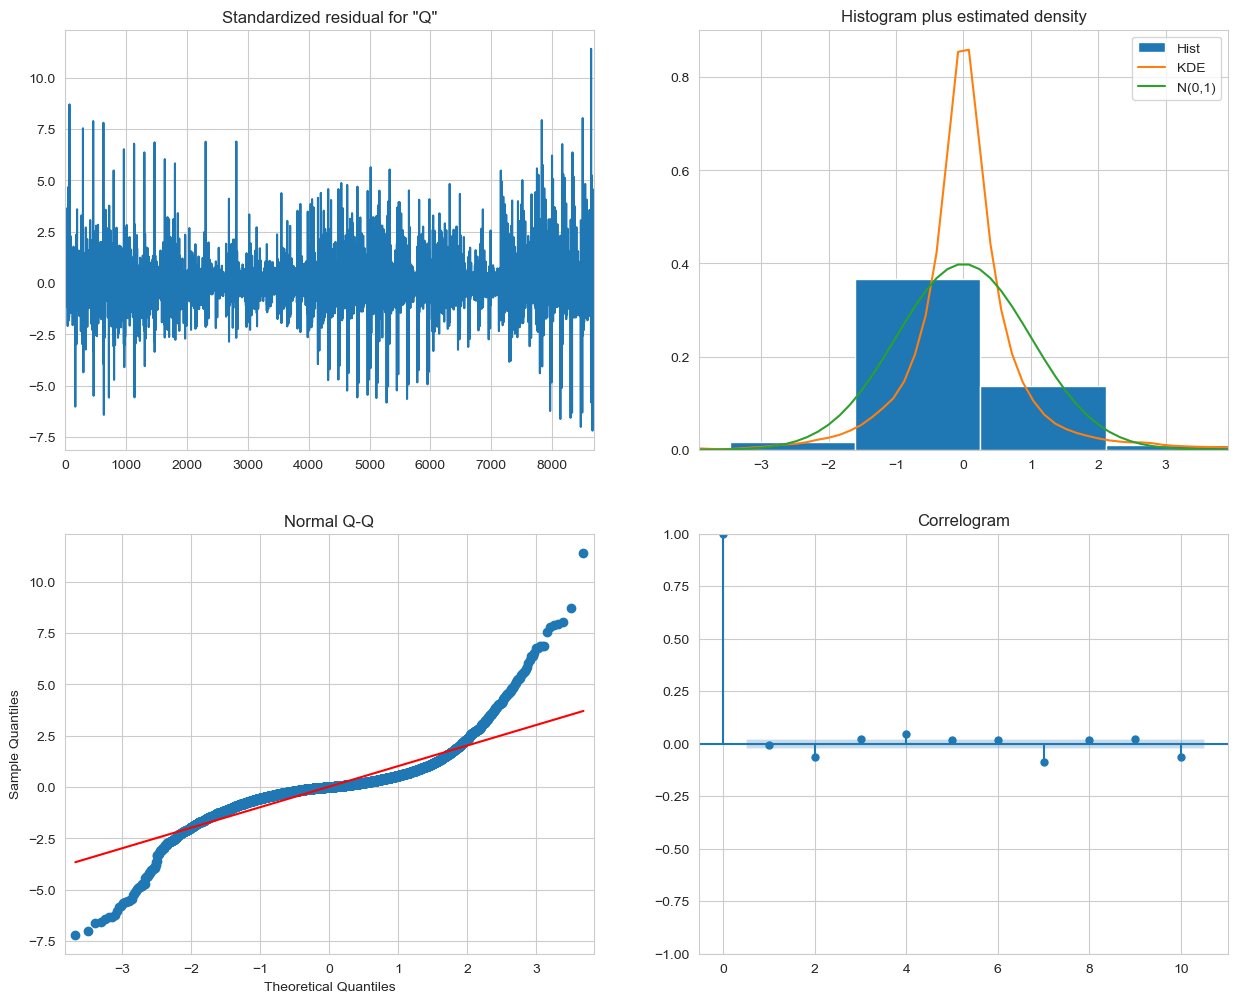

In [24]:
import matplotlib.pyplot as plt

# Diagnostic plots for the SARIMA model of 'Account A - QUANTITY'
results_a_quantity.plot_diagnostics(figsize=(15, 12))
plt.show()

The provided diagnostic plots are part of the output from a SARIMA model's `plot_diagnostics` method. These plots are used to evaluate the validity of the model by examining the residuals (the differences between the observed values and the model's predictions). Here's an analysis of each plot:

1. **Top-Left: Standardized Residuals**
   - The standardized residuals plot shows the residuals over time.
   - Ideally, you want to see no clear pattern, with the residuals centered around zero.
   - In the plot, there seem to be spikes that suggest occasional large deviations from the mean. This could indicate potential outliers or sudden shifts in the data that the model isn't capturing.

2. **Top-Right: Histogram and Estimated Density**
   - This plot includes a histogram of the standardized residuals, along with a Kernel Density Estimation (KDE) and an overlay of the normal distribution.
   - The KDE line should ideally follow closely with the N(0,1) line if the residuals are normally distributed.
   - The histogram shows the distribution of the residuals. While there's a noticeable peak around zero, the fit is not perfect, suggesting the residuals may not be exactly normally distributed.

3. **Bottom-Left: Normal Q-Q**
   - The Q-Q plot compares the distribution of the residuals to a normal distribution.
   - Points lying on the red line indicate the residuals are normally distributed.
   - The plot shows some deviation from normality, particularly in the tails. This might suggest heavy tails in the distribution of residuals, which could mean the presence of outliers.

4. **Bottom-Right: Correlogram (ACF plot)**
   - This plot shows the autocorrelation of the residuals.
   - Ideally, you'd like to see autocorrelations that are not significantly different from zero, which would suggest the residuals are white noise.
   - The correlogram here shows that the autocorrelations within the confidence band (the blue shaded area) are not significant, which is a good sign and suggests that there is no autocorrelation in the residuals.

### Interpretation and Next Steps:

- The model might benefit from further refinement due to the presence of large residuals and the deviations from normality in the residuals.
- Investigate the cause of the spikes in the residuals. If they correspond to specific events or outliers, consider incorporating additional explanatory variables into the model or applying outlier correction techniques.
- The deviations from normality in the tails suggest that the data might have outliers or be subject to sudden shifts. A transformation of the data or a different modeling approach might be necessary.
- Since the residuals do not show significant autocorrelation, the model seems to have captured the time-dependent structure of the data well. However, the presence of heavy tails and potential outliers needs to be addressed.
- Consider alternative models or additional features that could better account for the variance and heavy tails observed in the residuals.
- Perform robustness checks or sensitivity analyses to understand how these outliers affect the model's forecasts and consider using robust methods if necessary.

In conclusion, the model diagnostics suggest that while the time-dependent structure of the data may be well-modeled, the distribution of the residuals and the presence of large deviations indicate that there could be room for improvement in the model's fit to the data.

/Users/zhengshenhe/anaconda3/envs/STAT4911_IGSEnergy/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/zhengshenhe/anaconda3/envs/STAT4911_IGSEnergy/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.92548D+00    |proj g|=  2.68676D-01


 This problem is unconstrained.



At iterate    5    f=  3.87753D+00    |proj g|=  6.57540D-01

At iterate   10    f=  3.85773D+00    |proj g|=  5.26909D-02

At iterate   15    f=  3.85073D+00    |proj g|=  7.00471D-02

At iterate   20    f=  3.80443D+00    |proj g|=  4.24425D-01

At iterate   25    f=  3.76966D+00    |proj g|=  4.49712D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     27     40      1     0     0   1.023D-05   3.770D+00
  F =   3.7696562118296293     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Users/zhengshenhe/anaconda3/envs/STAT4911_IGSEnergy/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/zhengshenhe/anaconda3/envs/STAT4911_IGSEnergy/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


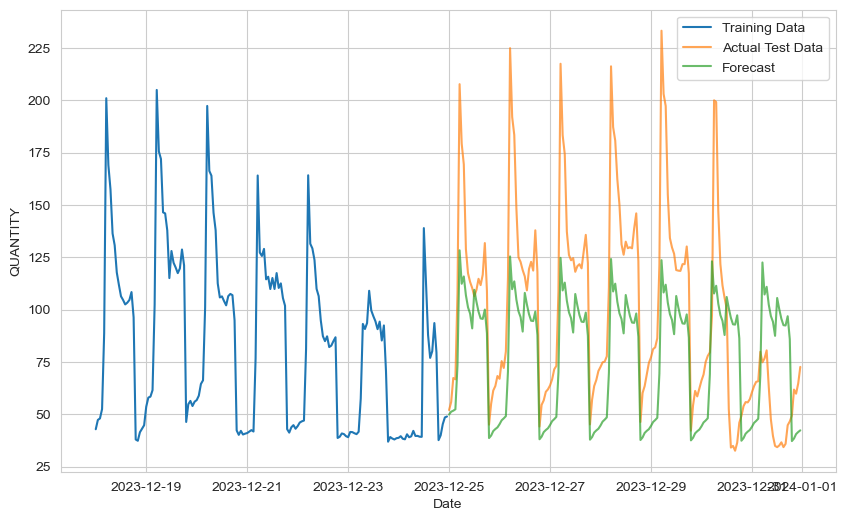

In [27]:
import numpy as np
# Assuming you have the 'account_a_hourly_filled' DataFrame ready
# Make sure the index is in the right datetime format
account_a_hourly_filled.index = pd.to_datetime(account_a_hourly_filled.index)

# Assuming the DataFrame is sorted, select the last week of the year for testing
train = account_a_hourly_filled['QUANTITY'][:-7*24]
test = account_a_hourly_filled['QUANTITY'][-7*24:]

# Fit the SARIMA model on the training data
model_train = SARIMAX(train,
                      order=(1, 0, 1),
                      seasonal_order=(1, 0, 1, 24),
                      enforce_stationarity=False,
                      enforce_invertibility=False)
results_train = model_train.fit()

# Forecast the one-week period
forecast = results_train.get_forecast(steps=7*24)
forecast_mean = forecast.predicted_mean

# Ensure the forecast index matches the test set index
forecast_mean.index = test.index

# Plot the forecast against the observed values
plt.figure(figsize=(10, 6))
plt.plot(train.index[-7*24:], train.iloc[-7*24:], label='Training Data')
plt.plot(test.index, test, label='Actual Test Data', alpha=0.7)
plt.plot(forecast_mean.index, forecast_mean, label='Forecast', alpha=0.7)
plt.xlabel('Date')
plt.ylabel('QUANTITY')
plt.legend()
plt.show()

In [18]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test, forecast_mean))
print(f"RMSE: {rmse}")

RMSE: 29.98194809694203


An RMSE (Root Mean Squared Error) of approximately 29.98 for the 'QUANTITY' forecast in Account A provides a quantitative measure of the model's forecast error. To interpret this value correctly, we need to consider the following:

Scale of 'QUANTITY': Compare the RMSE to the range or standard deviation of the 'QUANTITY' data. If 'QUANTITY' varies significantly (e.g., from 0 to several hundreds), an RMSE of 29.98 might indicate a reasonably good forecasting model. However, if 'QUANTITY' values are generally lower, an RMSE of this magnitude could be a sign of poor model performance.

Contextual Significance: Assess the RMSE in the context of your specific application or business needs. Depending on what the 'QUANTITY' represents and the stakes of making inaccurate predictions, even a small error might be critical, or a larger error might be acceptable.

Comparison with Baseline Models: Compare the RMSE of your SARIMA model with those of baseline models (such as a naïve forecast). If the SARIMA model does not significantly outperform a simple baseline, it might need refinement.

In [28]:
import pandas as pd
from prophet import Prophet

# Prepare the data for Prophet model for Account A
df_prophet_a = account_a_hourly_filled.reset_index()[['DateTime', 'QUANTITY']]
df_prophet_a.rename(columns={'DateTime': 'ds', 'QUANTITY': 'y'}, inplace=True)

# Prepare the data for Prophet model for Account B
df_prophet_b = account_b_hourly_filled.reset_index()[['DateTime', 'QUANTITY']]
df_prophet_b.rename(columns={'DateTime': 'ds', 'QUANTITY': 'y'}, inplace=True)

# Fit the Prophet model for Account A
model_a = Prophet(daily_seasonality=True, yearly_seasonality=True, weekly_seasonality=True)
model_a.fit(df_prophet_a)

# Fit the Prophet model for Account B
model_b = Prophet(daily_seasonality=True, yearly_seasonality=True, weekly_seasonality=True)
model_b.fit(df_prophet_b)

Importing plotly failed. Interactive plots will not work.
20:40:48 - cmdstanpy - INFO - Chain [1] start processing
20:40:48 - cmdstanpy - INFO - Chain [1] done processing
20:40:49 - cmdstanpy - INFO - Chain [1] start processing
20:40:49 - cmdstanpy - INFO - Chain [1] done processing


/Users/zhengshenhe/anaconda3/envs/STAT4911_IGSEnergy/lib/python3.10/site-packages/prophet/plot.py:71: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/zhengshenhe/anaconda3/envs/STAT4911_IGSEnergy/lib/python3.10/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',
/Users/zhengshenhe/anaconda3/envs/STAT4911_IGSEnergy/lib/python3.10/site-packages/prophet/plot.py:226: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version thi

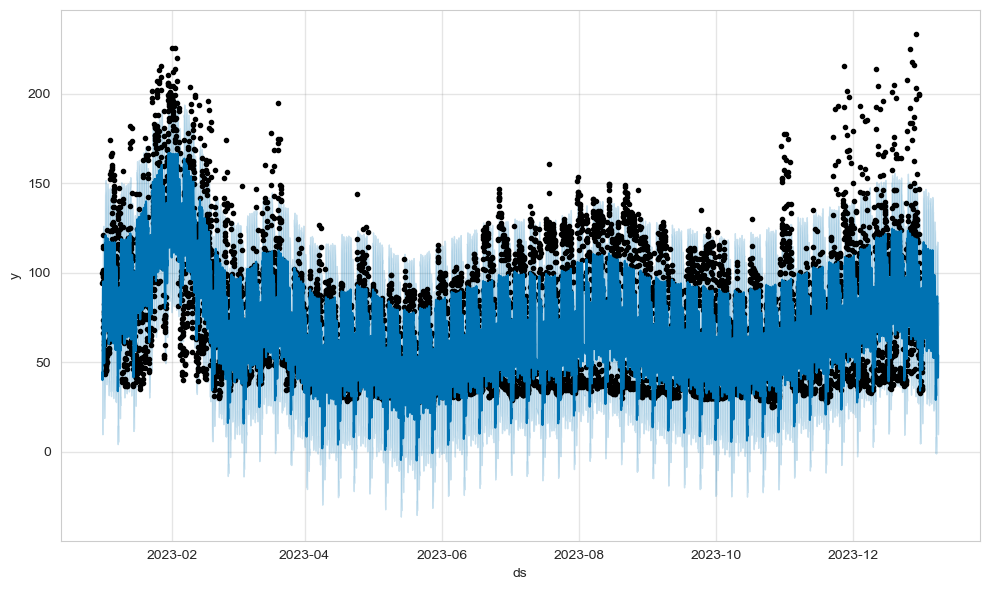

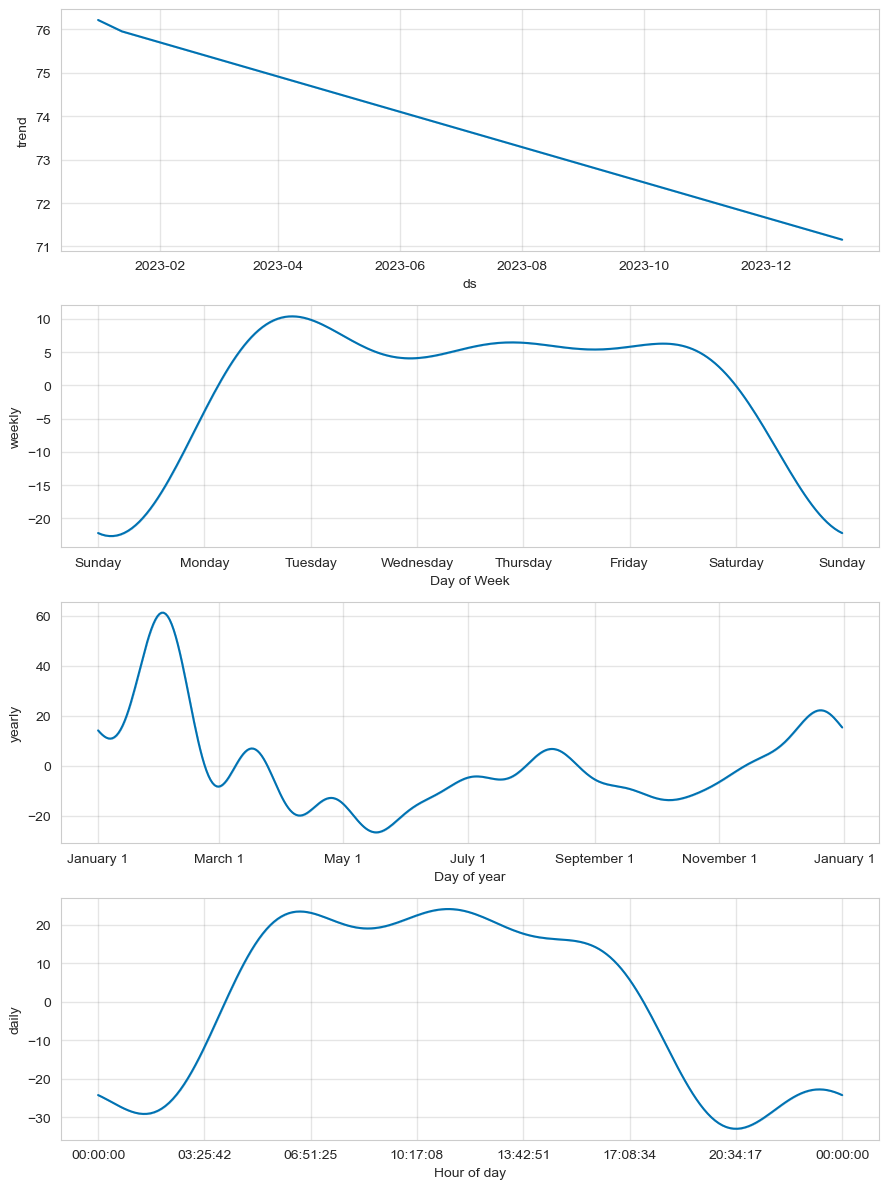

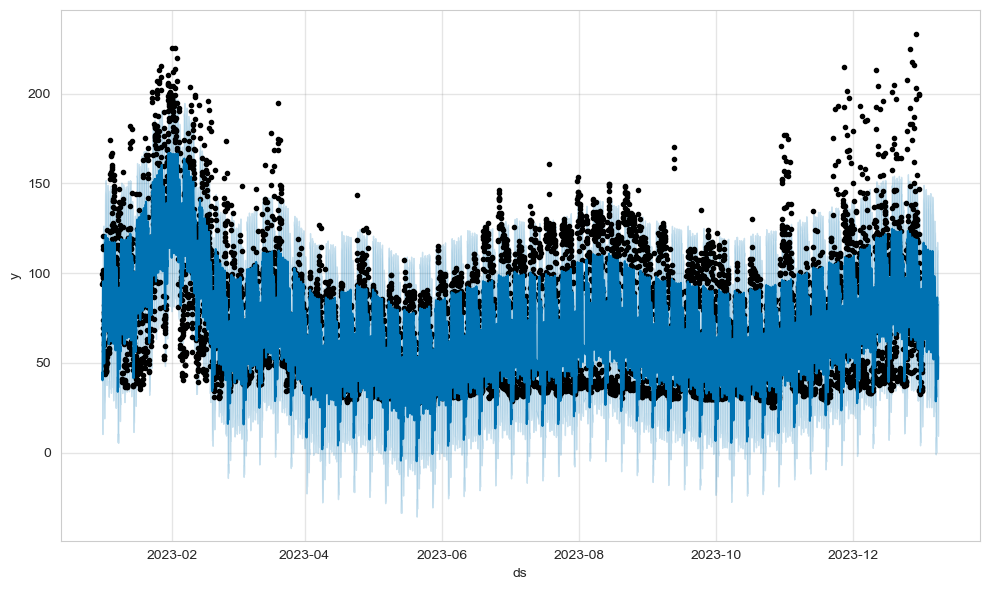

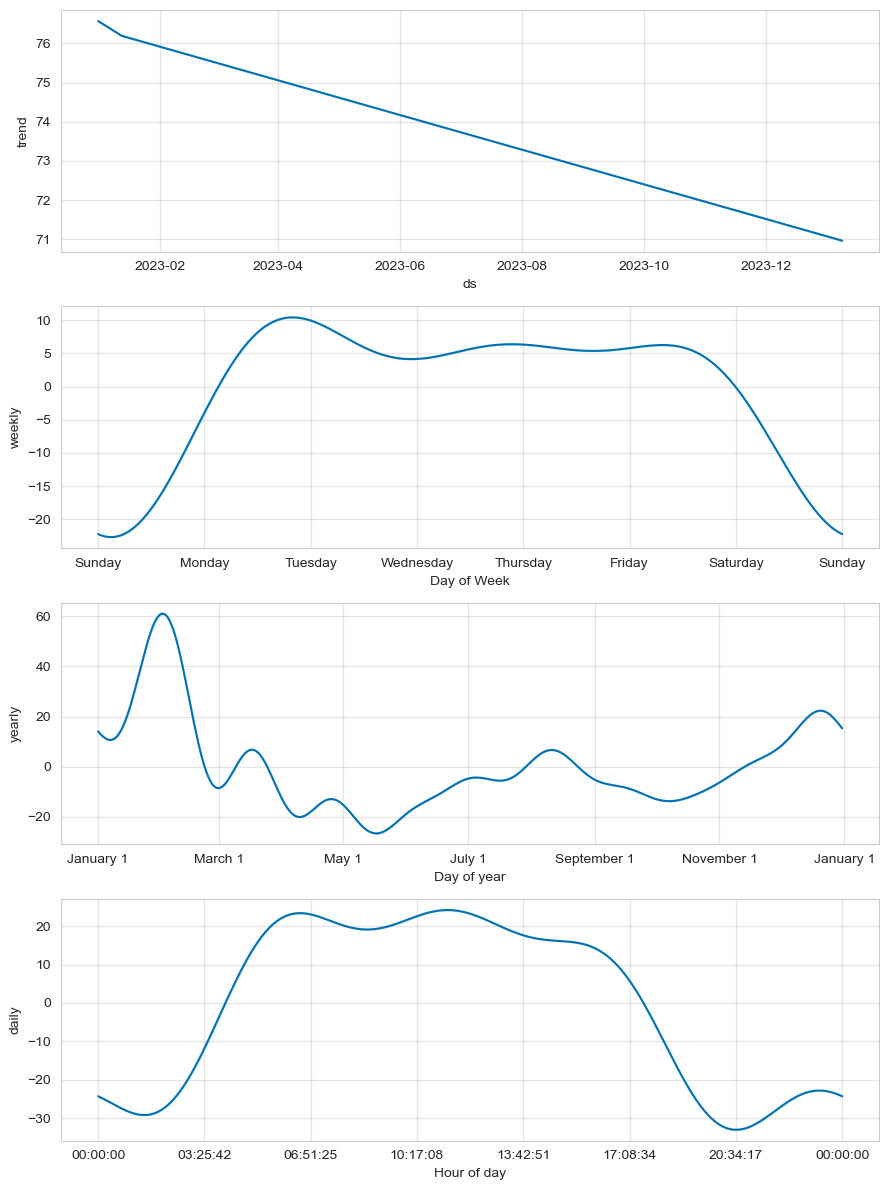

In [30]:
# Create a future dataframe for Account A for next week (7 days)
future_a = model_a.make_future_dataframe(periods=7*24, freq='H')

# Predict the future for Account A
forecast_a = model_a.predict(future_a)

# Create a future dataframe for Account B for next week (7 days)
future_b = model_b.make_future_dataframe(periods=7*24, freq='H')

# Predict the future for Account B
forecast_b = model_b.predict(future_b)
# Plot the forecast for Account A
fig1 = model_a.plot(forecast_a)
fig2 = model_a.plot_components(forecast_a)

# Plot the forecast for Account B
fig3 = model_b.plot(forecast_b)
fig4 = model_b.plot_components(forecast_b)

In [31]:
from sklearn.metrics import mean_squared_error

# Replace 'test_data_a' and 'test_data_b' with your actual test data for Account A and B
rmse_a = mean_squared_error(test, forecast_a['yhat'][-7*24:], squared=False)
rmse_b = mean_squared_error(test, forecast_b['yhat'][-7*24:], squared=False)

print(f"RMSE for Account A: {rmse_a}")
print(f"RMSE for Account B: {rmse_b}")

RMSE for Account A: 36.58247169806302
RMSE for Account B: 36.71425900983574
